In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, fcd, ld, matsz, rank):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.matsz = matsz
        self.rank = rank
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, matsz*rank).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)

    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        x = x.reshape(len(z), self.matsz, self.rank)
        x = torch.einsum('abc,adc->abd', x, x)
        return x

    def vectorize(self, x):
        a,b = np.triu_indices(self.matsz, 1)
        return x[:,a,b]

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(34716, 30, 264, 5)
vae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6_264_rank5.torch'))
vae.eval()

print('Done')

Done


In [2]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [3]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'
demo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
race = []
sex = []
age = []

a,b = np.triu_indices(264,1)

for sub in demo['age_at_cnb']:
    try:
        ra = demo['Race'][sub]
        ag = demo['age_at_cnb'][sub]
        se = demo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(remap(vec2mat(r))[a,b])
        nback.append(remap(vec2mat(n))[a,b])
        emoid.append(remap(vec2mat(e))[a,b])
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

age = (age - np.mean(age)) / np.std(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193,), (1193,), (1193,)]


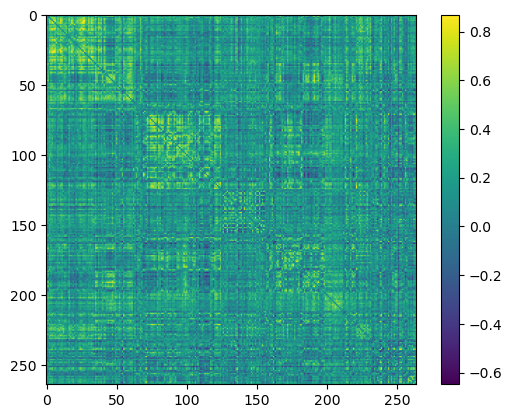

In [4]:
import matplotlib.pyplot as plt

plt.imshow(vec2mat(rest[0]))
plt.colorbar()
plt.show()

In [5]:
def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

rest_t = torch.from_numpy(rest).float().cuda()
nback_t = torch.from_numpy(nback).float().cuda()
emoid_t = torch.from_numpy(emoid).float().cuda()

age_t = torch.from_numpy(age).float().cuda()
sex_t = torch.from_numpy(sex).float().cuda()
race_t = torch.from_numpy(race).float().cuda()
ones = torch.ones(len(race)).float().cuda()

z = vae.enc(rest_t)

print('Done')

tensor(0.2428, device='cuda:0')
tensor(0.2088, device='cuda:0', grad_fn=<PowBackward0>)
tensor(0.2456, device='cuda:0')
tensor(0.2155, device='cuda:0', grad_fn=<PowBackward0>)


In [76]:
diff = np.mean(emoid, axis=0)-np.mean(rest, axis=0)
hat = rest+np.expand_dims(diff, 0)

err = np.mean((hat-emoid)**2, axis=1)**0.5
print(np.mean(err))
print(np.std(err))

0.23499115310640795
0.06230933112811834


In [75]:
err = np.mean((rest-emoid)**2, axis=1)**0.5
print(np.mean(err))
print(np.std(err))

0.2375461318767897
0.062408850571818095


In [126]:
with torch.no_grad():
    best = torch.ones(len(z)).float().cuda()
    avg = torch.zeros(len(z)).float().cuda()
    n = 100
    sigma = 0.1
    orig_sigma = 1/(10**0.5)
    var = sigma**2 + orig_sigma**2
    mult = orig_sigma/(var**0.5)
    
    for _ in range(n):
        rand = sigma*torch.randn(len(z),30).float().cuda()
        zp = (z + rand)*mult
        hat = vae.dec(zp, age_t, sex_t, race_t, 0*ones, 0*ones, 1*ones)[:,a,b]
        err = torch.mean((emoid_t-hat)**2, dim=1)**0.5
        best[err < best] = err[err < best]
        avg += err/n

print(torch.mean(best))
print(torch.std(best))
print(torch.mean(avg))
print(torch.std(avg))

tensor(0.1833, device='cuda:0')
tensor(0.0416, device='cuda:0')
tensor(0.2100, device='cuda:0')
tensor(0.0522, device='cuda:0')


In [94]:
# Null model

avgs = []

for _ in range(50):
    idcs = np.random.permutation(len(rest))
    err = np.mean((emoid-emoid[idcs])**2, axis=1)**0.5
    avgs.append(err)

avgs = np.concatenate(avgs)

print(np.mean(avgs))
print(np.std(avgs))

0.28885886447328385
0.0648664487669235


In [114]:
from sklearn.model_selection import train_test_split

class ImputeMLP(nn.Module):
    def __init__(self):
        super(ImputeMLP, self).__init__()
        self.fc1 = nn.Linear(34716, 2000).float().cuda()
        self.fc2 = nn.Linear(2000, 2000).float().cuda()
        self.fc3 = nn.Linear(2000, 2000).float().cuda()
        self.fc4 = nn.Linear(2000, 34716).float().cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def pretty(x):
    return f'{round(float(x), 4)}'

mlp = ImputeMLP()
optim = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=1e-5)

train, test = train_test_split(np.arange(len(rest)), train_size=1000)

x = rest_t[train]
y = emoid_t[train]

nepochs = 200
pperiod = 50

for e in range(nepochs):
    optim.zero_grad()
    xx = mlp(x)
    loss = rmse(xx, y)
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss)}')

print('Done')

with torch.no_grad():
    xx = mlp(rest_t[test])
    err = torch.mean((xx-emoid_t[test])**2, dim=1)**0.5
    print(torch.mean(err))
    print(torch.std(err))

0 0.3628
50 0.1939
100 0.1811
150 0.1794
199 0.1714
Done
tensor(0.2028, device='cuda:0')
tensor(0.0534, device='cuda:0')
